In [60]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from common import get_backtest_result, get_dual_backtest_result, get_hodl_result, max_drawdown, get_cache_path, save_cache_data, load_cache_data

In [61]:
# Input
exchanges_markets = {
    "binance": "BTCUSDT",
    "bitmex": "XBTUSD",
    "apollox": "BTCUSDT",
    "drift": "BTC-PERP"
}

hedge_map = {
    "binance": "bitmex",
    "bitmex": "binance",
    "apollox": "binance",
    "drift": "binance"
}

funding_freq_map = {
    "BTCUSDT": 8,
    "XBTUSD": 8,
    "BTCUSDT": 8,
    "BTC-PERP": 1,
    "ETHUSDT": 8,
    "ETHUSD": 8,
    "ETHUSDT": 8,
    "ETH-PERP": 1,
    "SOLUSDT": 8,
    "SOLUSD": 8,
    "SOLUSDT": 8,
    "SOL-PERP": 1,
    "XRPUSDT": 8,
    "XRPUSD": 8,
    "XRPUSDT": 8,
    "XRP-PERP": 1,
    "BNBUSDT": 8,
    "BNBUSD": 8,
    "BNBUSDT": 8,
    "BNB-PERP": 1,
}

market_name = exchanges_markets['binance'].replace('USDT', '')

In [62]:
# Compute all combinations of funding rate PNL

# Initial variables
min_time = datetime.fromisoformat('2023-08-01').timestamp()
max_time = datetime.fromisoformat('2024-02-29').timestamp()

data_df_map = {}
results = {}

leverages = [1, 3, 5, 7]

# Read data from file
for exchange, market in exchanges_markets.items():
    data_df = load_cache_data(exchange, market)
    
    if exchange not in data_df_map:
        data_df_map[exchange] = {}
    data_df_map[exchange][market] = data_df

# calculate min max time
for exchange, market in exchanges_markets.items():
    data_df = data_df_map[exchange][market]
    min_time = max(min_time, data_df["timestamp"].min())
    max_time = min(max_time, data_df["timestamp"].max())

# Calculate funding rate backtest result
for exchange, market in exchanges_markets.items():
    short_df = data_df_map[exchange][market]
    short_df['datetime'] = short_df['datetime'].apply(lambda x: pd.to_datetime(x))
    short_df = short_df[
        (short_df["timestamp"] >= min_time) & (short_df["timestamp"] <= max_time)
    ]
    short_df = short_df.sort_values(by='datetime', ascending=True)
    short_df = short_df.reset_index(drop=True)
    
    long_exchange = hedge_map[exchange]
    long_market = exchanges_markets[long_exchange]
    long_df = data_df_map[long_exchange][long_market]
    long_df['datetime'] = long_df['datetime'].apply(lambda x: pd.to_datetime(x))
    long_df = long_df[
        (long_df["timestamp"] >= min_time) & (long_df["timestamp"] <= max_time)
    ]
    long_df = long_df.sort_values(by='datetime', ascending=True)
    long_df = long_df.reset_index(drop=True)

    if exchange not in results:
        results[exchange] = {}
    if market not in results[exchange]:
        results[exchange][market] = {}

    for leverage in leverages:
        if leverage == 1:
            result_df = get_backtest_result(short_df, leverage)
        else:
            (result_df, _, _) = get_dual_backtest_result(long_df, short_df, funding_freq_map[long_market], funding_freq_map[market], leverage)
        results[exchange][market][leverage] = result_df

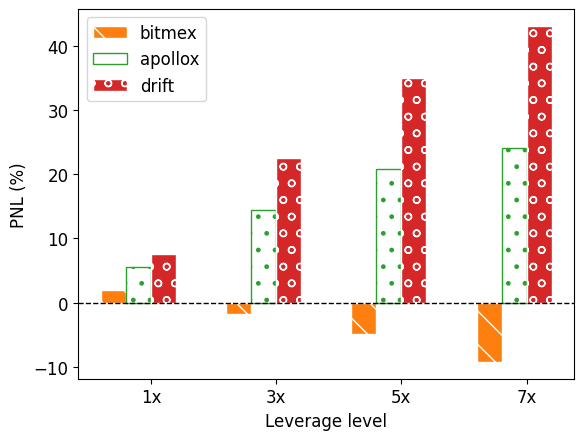

In [63]:

import json

hatche_map = {
    # "binance": "/",
    "bitmex": "\\",
    "apollox": ".",
    "drift": "o"
}
edgecolor_map = {
    # "binance": "C0",
    "bitmex": "white",
    "apollox": "C2",
    "drift": "white"
}
color_map = {
    # "binance": "white",
    "bitmex": "C1",
    "apollox": "white",
    "drift": "C3"
}

pnl_data = {}

# Plotting the bars with different hatch styles
bar_width = 0.4  # Adjust the width of the bars as per your preference

for l in leverages:
    for exchange, market in exchanges_markets.items():
        if exchange == "binance":
            continue
        if exchange not in pnl_data:
            pnl_data[exchange] = {}
        pnl_data[exchange][l] = results[exchange][market][l]['final_pnl'].iloc[-1] * 100
            
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
 
for index, (exchange, hatch) in enumerate(hatche_map.items()):
    values = list(pnl_data[exchange].values())
    plt.bar(
        [i + index * bar_width for i in leverages], 
        values, 
        edgecolor=edgecolor_map[exchange],
        color=color_map[exchange],
        hatch=hatch,
        width=bar_width,
        align='center',
        label=exchange
    )
              
# Adding labels and title
plt.xlabel('Leverage level', fontsize=12)
plt.ylabel('PNL (%)', fontsize=12)

# Assuming 'leverages' is a list of numerical values like [1, 3, 5, 7]
formatted_leverages = [f'{x}x' for x in leverages]
# Adjusting the x-ticks to show '1x', '3x', '5x', '7x', etc.
plt.xticks([i + 1.5 * bar_width for i in leverages], formatted_leverages, fontsize=12) 
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

end_path = f'/leverage_bar_{market_name}'
# Save the plot as a high-resolution image suitable for academic paper
plt.savefig(f'./images/{end_path}.png', dpi=300)
with open(f'./output/{end_path}.json', "w") as f:
    json.dump(pnl_data, f)

# Show the plot
plt.show()
